### Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

### Задача 1.
#### В первую очередь, его интересует показатель retention. Необходимо написать функцию для его подсчета.



In [6]:
# выгружаем нужные библтотеки

import pandas as pd
import numpy as np
from datetime import datetime
from operator import attrgetter
import seaborn as sns
import matplotlib.pyplot as plt

#### Приступаем к непосредственному написанию функции:

In [2]:
def retention(reg_data_url, auth_data_url, first_day, last_day):
    
    # Загружаем данные
    reg_data = pd.read_csv(reg_data_url, sep=';')
    auth_data = pd.read_csv(auth_data_url, sep=';')
    
    # Мерждим две таблицы
    all_data = reg_data.merge(auth_data, how='left', on='uid')
    
    # Сбарсываем дубликаты и пропуски
    all_data = all_data.drop_duplicates().dropna()
    
    # Преобразовываем даты в формат даты (год/месяц/день)
    all_data['reg_ts'] = (pd.to_datetime(all_data['reg_ts'], unit="s")).map( lambda x: x.strftime('%Y-%m-%d'))
    all_data['auth_ts'] =(pd.to_datetime(all_data['auth_ts'], unit="s")).map( lambda x: x.strftime('%Y-%m-%d'))
    
    all_data['reg_ts'] = pd.to_datetime(all_data['reg_ts'])
    all_data['auth_ts'] = pd.to_datetime(all_data['auth_ts'])
    
    # Создаем возможность задавать нужный интервал даты
    all_data = all_data[(all_data.reg_ts >= pd.to_datetime(first_day)) & (all_data.auth_ts <= pd.to_datetime(last_day))]
    
    # определяем частоту периодов - у нас суточная
    all_data['entry_day'] = all_data['auth_ts'].dt.to_period('D')
    
    # создаем когорты пользователей по дате регистрации
    all_data['cohort'] = all_data.groupby('uid')['reg_ts']\
        .transform('min') \
        .dt.to_period('D') 
    
    
    # Объединяем данные по когорте и захода пользователей в игру за день 
    # и подсчитываем количество уникальных клиентов в каждой группе. 
    df_cohorts = all_data.groupby(['cohort','entry_day'])\
    .agg({'uid':'nunique'}) \
    .reset_index(drop=False)\
    .rename(columns = {'uid':'count_users'})
    
    # Добавляем число_периода, которое указывает количество периодов между днем когорты и днем захода.
    df_cohorts['period_number'] = (df_cohorts.entry_day - df_cohorts.cohort).apply(attrgetter('n')).astype(int)
    
    # Используя pivot  поворачиваем таблицу df_cohorts таким образом, чтобы каждая строка содержала информацию 
    # о данной когорте, а каждый столбец содержал значения за определенный период.
    df_cohorts = df_cohorts.pivot_table(index='cohort',
                                         columns='period_number',
                                         values='count_users')

    # Чтобы получить матрицу удержания, нам нужно разделить значения каждой строки на первое значение строки, 
    # которое на самом деле является размером когорты — все клиенты, которые сделали свою первый заход в игру.
    
    cohort_size = df_cohorts.iloc[:,0] # выбрала значения первого столбика(т.е размер количество пользователей первого дня)
    retention_matrix = df_cohorts.divide(cohort_size, axis = 0)*100

    return retention_matrix

In [33]:
retention_matrix = retention('problem1-reg_data.csv','problem1-auth_data.csv', '2018-09-21','2018-10-21')

In [34]:
retention_matrix

period_number,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
cohort,,,,,,,,,,,,,,,,,,,,,
2018-09-21,100.0,1.829268,2.845528,2.845528,3.455285,5.894309,5.691057,5.691057,3.252033,5.284553,...,3.252033,1.626016,2.642276,3.455285,1.219512,2.845528,2.235772,1.626016,1.626016,1.829268
2018-09-22,100.0,2.226721,4.453441,3.238866,3.441296,5.263158,8.704453,5.060729,5.060729,3.846154,...,4.251012,2.429150,4.251012,2.631579,2.429150,3.643725,2.834008,3.036437,1.821862,NaN
2018-09-23,100.0,2.834008,2.226721,3.846154,5.060729,7.085020,6.477733,5.668016,2.834008,4.453441,...,3.238866,3.238866,2.834008,3.846154,2.429150,3.238866,2.631579,2.631579,NaN,NaN
2018-09-24,100.0,2.424242,4.040404,5.050505,3.838384,7.070707,7.474747,6.060606,4.444444,4.444444,...,4.848485,3.636364,4.444444,3.030303,4.040404,4.040404,3.636364,NaN,NaN,NaN
2018-09-25,100.0,2.016129,4.032258,4.435484,5.040323,5.040323,6.048387,7.056452,5.040323,4.637097,...,3.427419,3.629032,5.040323,3.024194,4.032258,4.435484,NaN,NaN,NaN,NaN
2018-09-26,100.0,2.217742,3.830645,5.846774,5.846774,5.443548,8.064516,7.056452,5.241935,3.629032,...,3.629032,3.024194,4.032258,2.822581,3.225806,NaN,NaN,NaN,NaN,NaN
2018-09-27,100.0,1.004016,3.413655,6.626506,3.815261,6.827309,6.425703,4.819277,5.220884,4.819277,...,3.212851,3.212851,3.815261,4.216867,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-28,100.0,2.008032,4.417671,3.413655,4.216867,6.024096,7.028112,6.425703,3.815261,5.421687,...,2.811245,2.811245,3.815261,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-29,100.0,2.404810,3.607214,4.809619,5.611222,6.412826,6.212425,4.609218,4.208417,4.408818,...,4.408818,3.406814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Для более наглядного результата можно визуализировать полученные данные, выбрав интересующую нас когорту:

<AxesSubplot:xlabel='period_number'>

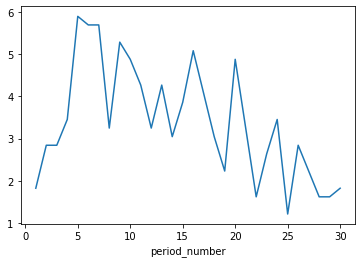

In [36]:
retention_matrix.loc['2018-09-21'][1:].plot()